<a href="https://colab.research.google.com/github/karthik1401/ZTM-reference-docs/blob/master/ETE_ZTM_Dog_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to End Multi-Class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 Hub.

## 1. Problem

Identifying the different kind of Dog Breeds given an image of a dog. 

## 2. Data

The data we're using is from Kaggle's dog breed identification competition. 

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed for each test image. 

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about this data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning. 
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the train set (they've labels)
* There are around 10,000+ images in test set (don't have labels)

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
# Changing the Working Directory
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [ ]:
# Checking the working directory
!pwd

/content/drive/My Drive/Kaggle


In [ ]:
#!pip install -q kaggle

In [ ]:
#!kaggle datasets list

# **We received warning error to update both server (kaggle) & client (pip)**


In [ ]:
#!pip uninstall -y kaggle
#!pip install --upgrade pip
#!pip install kaggle==1..5.6 

In [ ]:
# !kaggle -v

In [ ]:
# !pip --version

In [ ]:
# Connecting and downloading dataset from kaggle
#!kaggle competitions download -c dog-breed-identification

In [ ]:
# unzipping the zip file from Kaggle and deleting the zip files
# !unzip \*.zip && rm *.zip

## Get our workspace ready

* Import TensorFlow 2.x 
* Import TensorFlow Hub
* Make sure we're using a GPU

In [ ]:
# Import necessary tools
import tensorflow
import tensorflow_hub as hub
print('TF version', tensorflow.__version__)
print('TF Hub version: ', hub.__version__)

# Check for GPU availability
print('GPU', 'available (YESSSSSSSSSS!!!!!!!)' if tensorflow.config.list_physical_devices('GPU') else 'Not Available :(')

# We need TensorFlow 2.0 only, not the previous version. 

TF version 2.2.0
TF Hub version:  0.8.0
GPU available (YESSSSSSSSSS!!!!!!!)


## Getting our data ready (turning into Tensors)

With all ML models, our data has to be in numerical format. So, that's what we'll be doing first. Turning our images into Tensors. 

Let's start by accessing our data and checking out labels. 

In [ ]:
# Checkout the labels of our data

import pandas

labels_csv = pandas.read_csv('labels.csv')
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,8a766975e00b9ce3b75899ecebde5a71,scottish_deerhound
freq,1,126


In [ ]:
# How many images are there of each breed?
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

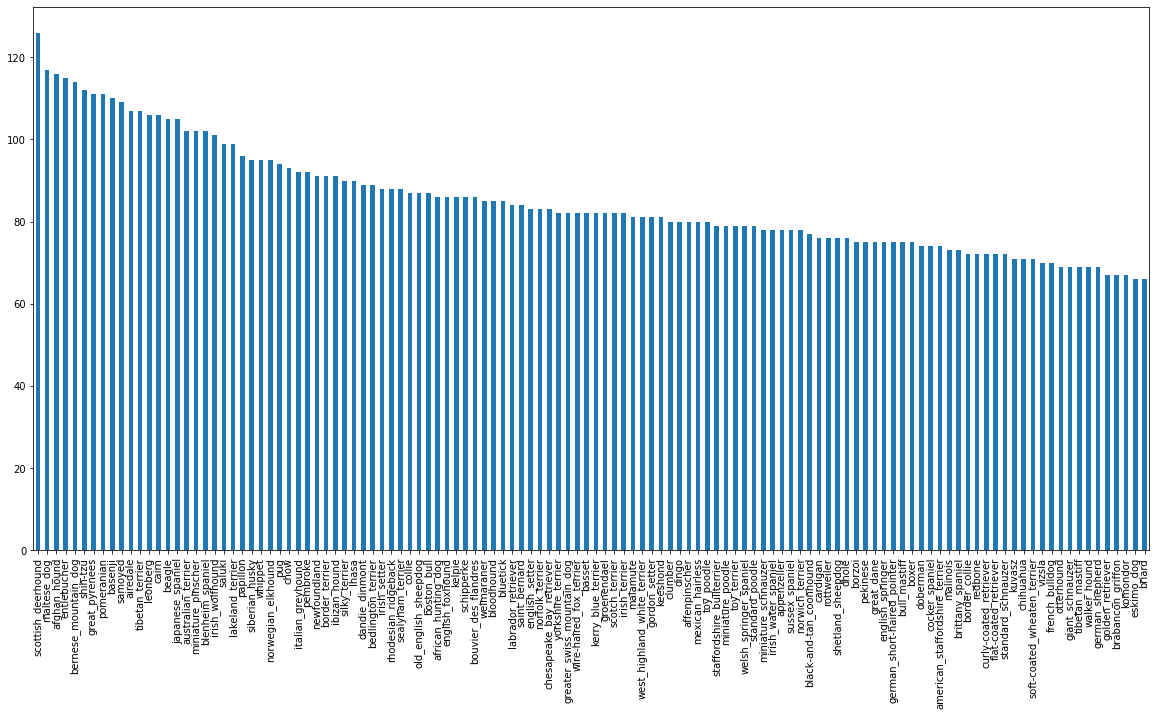

In [ ]:
labels_csv['breed'].value_counts().plot.bar(figsize = (20, 10));

In [ ]:
labels_csv['breed'].value_counts().median()

82.0

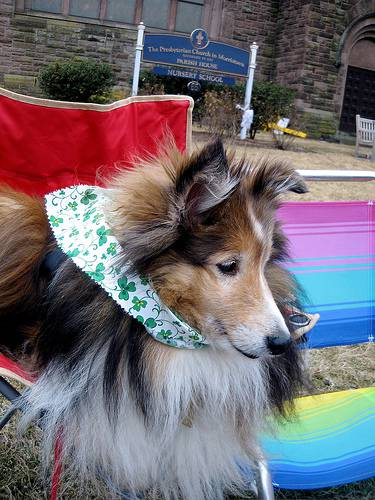

In [ ]:
# Let's view an image
from IPython.display import Image
Image('train/004396df1acd0f1247b740ca2b14616e.jpg')

### Getting images and their labels

Let's get a list of all of our image file pathnames. 

In [ ]:
# Create pathname from image ID's
filenames = ['train/' + fname + '.jpg' for fname in labels_csv['id']]

# Check the first 10
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('train/')) == len(filenames):
  print('Filenames match actual amount of files!! Proceed.')
else:
  print('Filenames do no match actual amount of files, check the target folder!')

Filenames match actual amount of files!! Proceed.


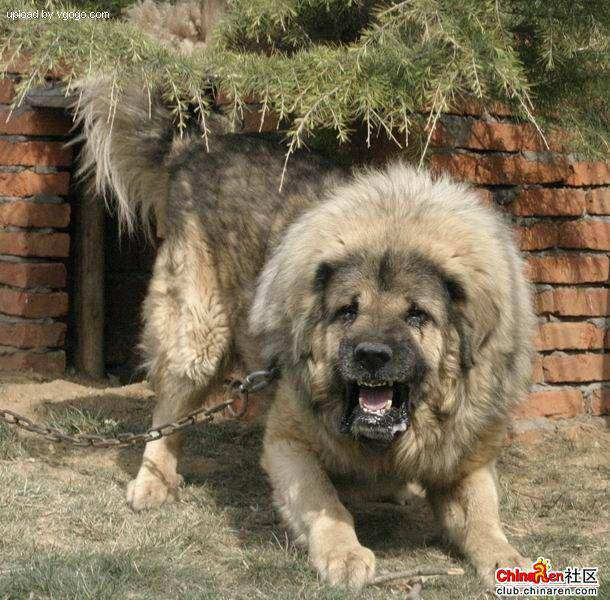

In [ ]:
# One more check 
Image(filenames[9000])

In [ ]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels. 

In [ ]:
import numpy
labels = labels_csv['breed']
labels = numpy.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print('Number of labels matches number of filenames!')
else:
  print('Number of labels does not matches number of filenames, check data directories!')

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = numpy.unique(labels)
unique_breeds[:10]

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle'], dtype=object)

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])

labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean Array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:1]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False])]

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(numpy.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own. 

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type : "slider", min: 1000, max: 10000, step: 100}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES],
                                                  test_size = 0.2, 
                                                  random_state = 42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a geez at the training data

X_train[:1], y_train[:1]

(['train/00bee065dcec471f26394855c5c2f3de.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,

## Pre-processing Images(turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [ ]:
# Convert an image to NumPy array

from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
# Turning image into TensorFlow
tensorflow.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them. 

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images.
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  
  # Read in an image file
  image = tensorflow.io.read_file(image_path)

  # Turn the jpeg image to numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tensorflow.image.decode_jpeg(image, channels = 3)

  # Convert the colour channel values from 0-255 to 0-1 values
  image = tensorflow.image.convert_image_dtype(image, tensorflow.float32)

  # Resize the image to our desired value (224, 224)
  image = tensorflow.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... They all might not fit into memory.

So, that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label, processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  
  return image, label

In [ ]:
# Demo of the above
(process_image(X[42], tensorflow.constant(y[42])))

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create function to turn data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data. 
  Also, accepts test data as input (no labels).
  """

  # If the data is test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    
    data = tensorflow.data.Dataset.from_tensor_slices((tensorflow.constant(X))) # Only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)

    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches')

    data = tensorflow.data.Dataset.from_tensor_slices((tensorflow.constant(X), # filepaths
                                                       tensorflow.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)

    return data_batch

  else:
    print('Creating training data batches...')

    # Turn filepaths and labels into Tensors
    data = tensorflow.data.Dataset.from_tensor_slices((tensorflow.constant(X), tensorflow.constant(y)))
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffle.
    data = data.shuffle(buffer_size = len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)

    return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches...
Creating validation data batches


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches 

Our data is now in batches, however, these can be a little hard to understand. Let's visualize them. 

In [ ]:
import matplotlib.pyplot as pyplot

# Create a function for viewving images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """

  # Setup the figure
  pyplot.figure(figsize = (12, 10))

  # Loop through 25 (for displaying)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = pyplot.subplot(5, 5, i+1)

    # Display an image
    pyplot.imshow(images[i])

    # Add the image label as the title
    pyplot.title(unique_breeds[labels[i].argmax()])

    # Turn the grid lines off
    pyplot.axis('off')

In [ ]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

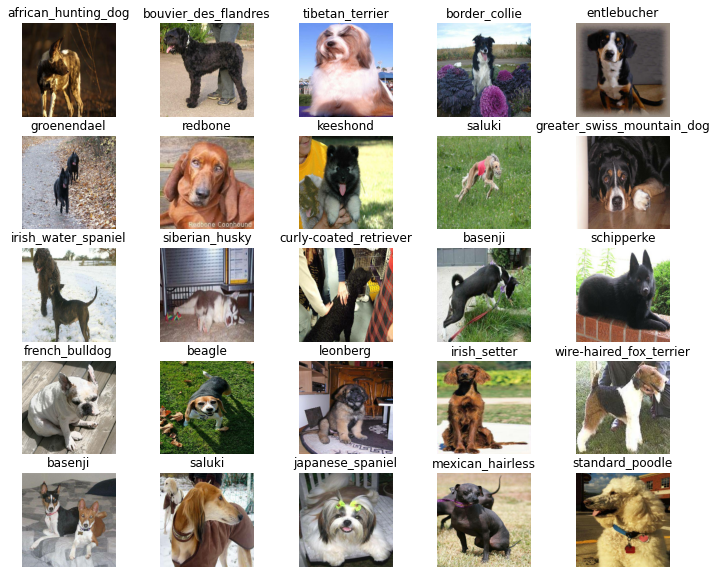

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())

# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

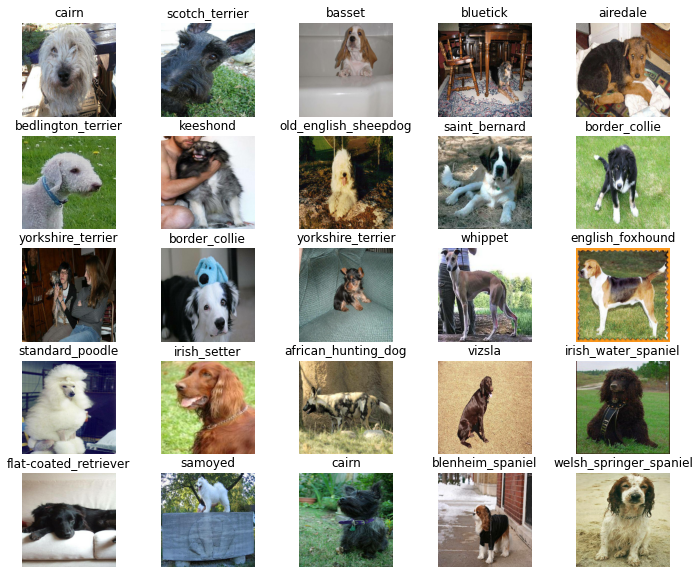

In [ ]:
# Now let's visualize the validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building our model

Before we build a model, there are a few things we need to define:
* The `input` shape (our image shapes, in the form of Tensors) to our model.
* The `output` shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub. 

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in Sequential fashion (do this in step by step).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview 

In [ ]:
# Create function which builds a Keras model

def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print('Building model with: ', model_url)

  # Setup the model layers
  model = tensorflow.keras.Sequential([hub.KerasLayer(MODEL_URL), # Layer 1 (Input Layer)
                tensorflow.keras.layers.Dense(units = OUTPUT_SHAPE,
                activation = 'softmax') # Layer 2 (output layer)
                ])
  
  # Compile the model
  model.compile(loss = tensorflow.keras.losses.CategoricalCrossentropy(),
                optimizer = tensorflow.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )
  
  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our models from training too long.

### TensorBoard Callback

To Setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after training).

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback

def create_tensorboard_callback():

  # Create a log directory for TensorBoard logs
  logdir = os.path.join('drive/My Drive/Kaggle/logs',
        # Make it so the logs get tracked whenever we run an experiment
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 
  
  return tensorflow.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback 

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving. 

In [ ]:
# Create early stopping callbacks
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working. 

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we're still running on a GPU
print('GPU', 'available (YESSSSS!!!!!!!!' if tensorflow.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

GPU available (YESSSSS!!!!!!!!


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [ ]:
# Deleting the logs folder
#!rm -rf ./content/

In [ ]:
# Build a function to train and return the trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """

  # Create amodel
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x = train_data, epochs = NUM_EPOCHS, validation_data = val_data, validation_freq = 1, callbacks = [tensorboard, early_stopping])

  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
 2/25 [=>............................] - ETA: 7s - loss: 5.8259 - accuracy: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.260098). Check your callbacks.


25/25 [==============================] - 6s 259ms/step - loss: 4.7557 - accuracy: 0.1000 - val_loss: 3.4914 - val_accuracy: 0.2400
Epoch 2/100
25/25 [==============================] - 6s 227ms/step - loss: 1.7401 - accuracy: 0.6562 - val_loss: 2.1731 - val_accuracy: 0.4900
Epoch 3/100
25/25 [==============================] - 6s 229ms/step - loss: 0.6016 - accuracy: 0.9212 - val_loss: 1.6463 - val_accuracy: 0.6100
Epoch 4/100
25/25 [==============================] - 6s 224ms/step - loss: 0.2610 - accuracy: 0.9875 - val_loss: 1.4596 - val_accuracy: 0.6550
Epoch 5/100
25/25 [==============================] - 6s 225ms/step - loss: 0.1525 - accuracy: 0.9937 - val_loss: 1.3698 - val_accuracy: 0.6700
Epoch 6/100
25/25 [==============================] - 6s 223ms/step - loss: 0.1043 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.6700
Epoch 7/100
25/25 [==============================] - 6s 225ms/step - loss: 0.0771 - accuracy: 1.0000 - val_loss: 1.2949 - val_accuracy: 0.6750
Epoch 8/100

**Question:** Looks like our model is overfitting, it's performing excellent with training dataset, than the validation dataset. What are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing, it means our model is learning!!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir drive/My\ Drive/Kaggle/logs

<IPython.core.display.Javascript object>

## Making and Evaluating Predictions using a trained model

In [ ]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Make Predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose = 1)
predictions

NameError: ignored

In [ ]:
predictions.shape

In [ ]:
# First prediction
index = 0
#print(predictions[0])
print(f'Max value (probability of prediction): {numpy.max(predictions[index])}')
print(f'Sum: {numpy.sum(predictions[index])}')
print(f'Max index: {numpy.argmax(predictions[index])}')
print(f'Predicted Label: {unique_breeds[numpy.argmax(predictions[index])]}')

Max value (probability of prediction): 0.2651970088481903
Sum: 0.9999998807907104
Max index: 26
Predicted Label: cairn


Having the above functionality is great but we want to be able to do it at large scale. 

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:
# Turn Prediction probabilities into their respective labels (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilites into a label.
  """
  return unique_breeds[numpy.argmax(prediction_probabilities)]

In [ ]:
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

Now since our validation data is still in a batch dataset, we'll have to unbathify it to make predictions on the validation images and then compare those predictions to the validation labels(truth labels).

In [ ]:
# Create a function to unbatch the batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns seperate arrays of images and labels.
  """
  images = []
  labels = []

  # Looping through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[numpy.argmax(label)])
  
  return images, labels

In [ ]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction Labels
* Validation Labels
* Validation Images

Let's make some function to make these all a bit more visual.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integers.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, it's predicted probability, the truth label and the target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  pyplot.imshow(image)
  pyplot.xticks([])
  pyplot.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label, numpy.max(pred_prob)*100, true_label), color=color)

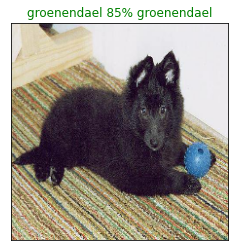

In [ ]:
plot_pred(prediction_probabilities=predictions, 
          labels = val_labels, 
          images = val_images, n = 77)

Now we've got one function to visualize our models predictions, let's make an another to view our models top 10 predictions. 

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n = 1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n.
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence  values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Stup plot
  top_plot = pyplot.bar(numpy.arange(len(top_10_pred_labels)),
                        top_10_pred_values,
                        color = 'grey')
  pyplot.xticks(numpy.arange(len(top_10_pred_labels)),
                labels = top_10_pred_labels, 
                rotation = 'vertical')
  
  # Change the color of the True Label
  if numpy.isin(true_label, top_10_pred_labels):
    top_plot[numpy.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass

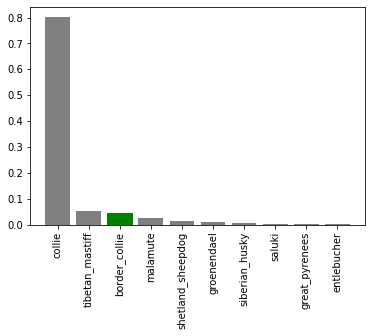

In [ ]:
plot_pred_conf(prediction_probabilities = predictions,
               labels = val_labels,
               n = 9)

Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

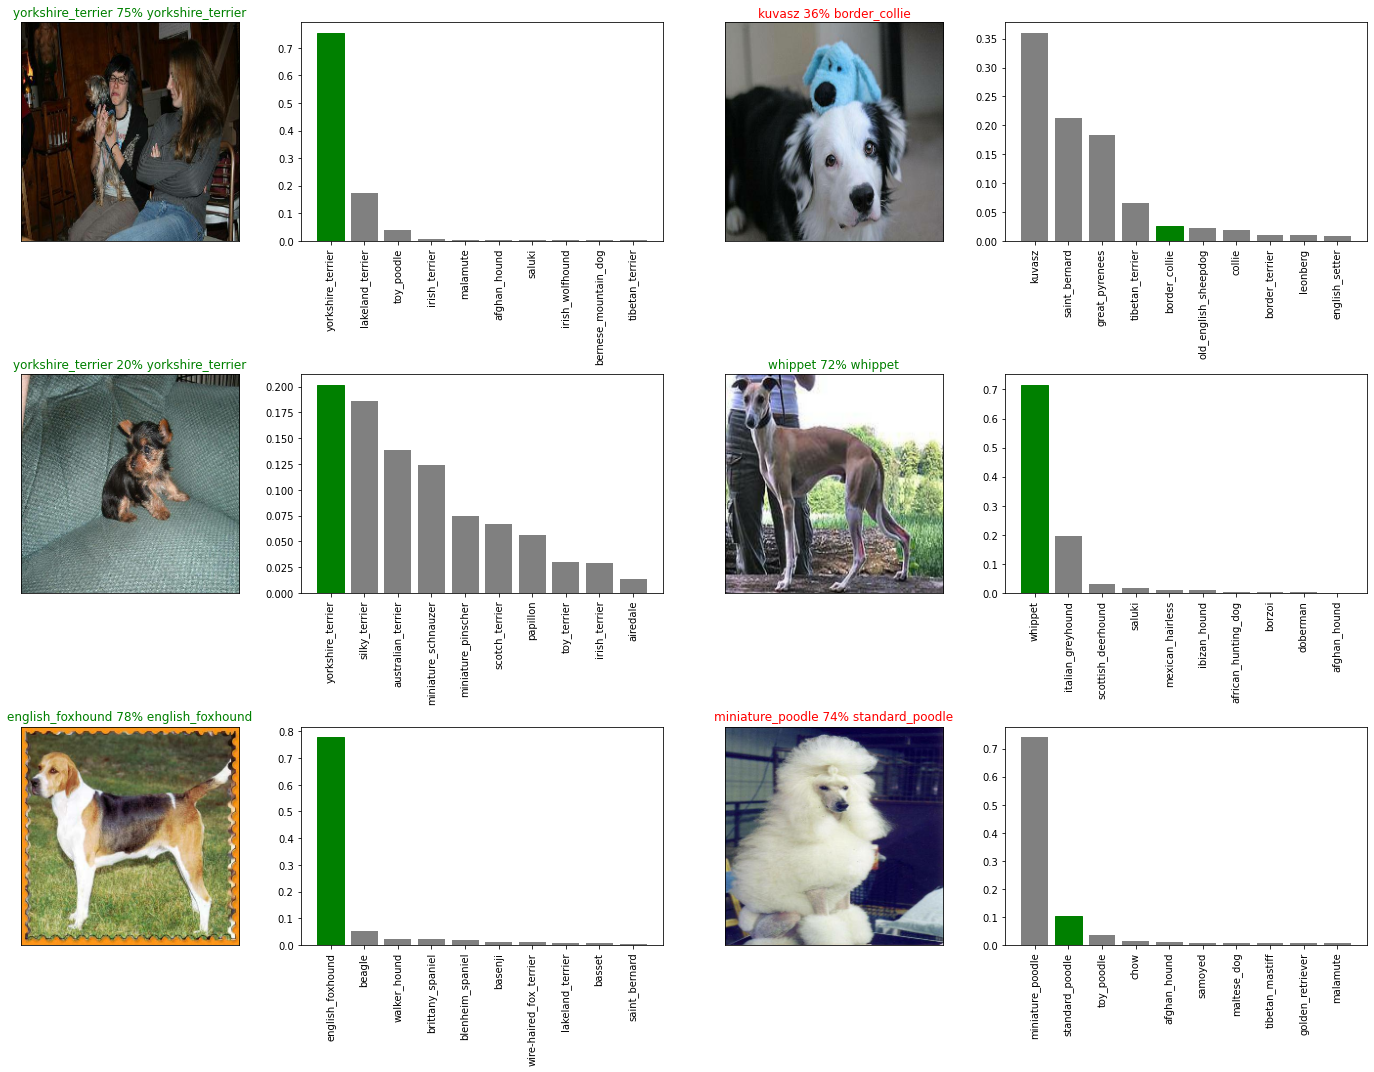

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
pyplot.figure(figsize = (10 * num_cols, 5 * num_rows))

for i in range(num_images):
  pyplot.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  
  plot_pred(prediction_probabilities = predictions,
            labels = val_labels,
            images = val_images,
            n = i + i_multiplier)
  
  pyplot.subplot(num_rows, 2 * num_cols, 2 * i+2)

  plot_pred_conf(prediction_probabilities = predictions, 
                 labels = val_labels,
                 n = i+i_multiplier)

  pyplot.tight_layout(h_pad = 1.0)

pyplot.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

## Saving and reloading a trained model

In [ ]:
# Create a function save a model

def save_model(model, suffix = None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """

  # Create a model directory pathname with current time
  modeldir = os.path.join('/content/drive/My Drive/Kaggle/models',
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  
  model_path = modeldir + "-" + suffix + ".h5" # Save format of model

  print(f"Saving model to: {model_path}...")

  model.save(model_path)

  return model_path

In [ ]:
# Function to Load a model

def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """

  print(f"Loading saved model from: {model_path}")

  model = tensorflow.keras.models.load_model(model_path,
                                             custom_objects = {'KerasLayer' : hub.KerasLayer})
  
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [ ]:
# Save our model trained on 1000 images

save_model(model, suffix = "1000-images-ADAM-mobilenetv2")

Saving model to: /content/drive/My Drive/Kaggle/models/20200527-12131590581592-1000-images-ADAM-mobilenetv2.h5...


'/content/drive/My Drive/Kaggle/models/20200527-12131590581592-1000-images-ADAM-mobilenetv2.h5'

In [ ]:
# Load a trained model

loaded_1000_image_model = load_model("/content/drive/My Drive/Kaggle/models/20200527-12131590581592-1000-images-ADAM-mobilenetv2.h5")

Loading saved model from: /content/drive/My Drive/Kaggle/models/20200527-12131590581592-1000-images-ADAM-mobilenetv2.h5


In [ ]:
# Evaluate the pre-saved model

model.evaluate(val_data)

7/7 [==============================] - 1s 147ms/step - loss: 1.1953 - accuracy: 0.6900


[1.1952883005142212, 0.6899999976158142]

In [ ]:
# Evaluate the loaded model

loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 54s 8s/step - loss: 1.1953 - accuracy: 0.6900


[1.1952881813049316, 0.6899999976158142]

## Training a big dog model (on the full data)

In [ ]:
# Create a data batch with the full data set

full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a model for full data

full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor = "accuracy",
                                                                     patience = 3)

**Note:** Running the cell below will take a little while (maybe upto 30 mins for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 9672s 30s/step - loss: 1.3557 - accuracy: 0.6669
Epoch 2/100
320/320 [==============================] - 62s 194ms/step - loss: 0.4026 - accuracy: 0.8786
Epoch 3/100
320/320 [==============================] - 61s 192ms/step - loss: 0.2388 - accuracy: 0.9342
Epoch 4/100
320/320 [==============================] - 61s 192ms/step - loss: 0.1531 - accuracy: 0.9642
Epoch 5/100
320/320 [==============================] - 61s 191ms/step - loss: 0.1075 - accuracy: 0.9774
Epoch 6/100
320/320 [==============================] - 61s 190ms/step - loss: 0.0795 - accuracy: 0.9852
Epoch 7/100
320/320 [==============================] - 61s 189ms/step - loss: 0.0571 - accuracy: 0.9926
Epoch 8/100
320/320 [==============================] - 60s 188ms/step - loss: 0.0467 - accuracy: 0.9936
Epoch 9/100
320/320 [==============================] - 60s 189ms/step - loss: 0.0378 - accuracy: 0.9959
Epoch 10/100
320/320 [==============================] - 61s 190m

**Note:** It took 2 freaking hours for that piece of code to run!!!!!!!! 2 HOURS!!

In [ ]:
save_model(full_model, suffix = "full-image-set-mobilevnetv2-ADAM")

Saving model to: /content/drive/My Drive/Kaggle/models/20200527-15491590594577-full-image-set-mobilevnetv2-ADAM.h5...


'/content/drive/My Drive/Kaggle/models/20200527-15491590594577-full-image-set-mobilevnetv2-ADAM.h5'

In [ ]:
# Load the saved full model
loaded_full_model = load_model('/content/drive/My Drive/Kaggle/models/20200527-15491590594577-full-image-set-mobilevnetv2-ADAM.h5')

Loading saved model from: /content/drive/My Drive/Kaggle/models/20200527-15491590594577-full-image-set-mobilevnetv2-ADAM.h5


## Making Predictions on the Test Dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format. 

Luckily, we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches. 

To make predictions on the test data, we'll:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the `predict()` function.

In [ ]:
# Load the test image filenames (since, we're using os.listdir(), these already have .jpg)

test_path = "/content/drive/My Drive/Kaggle/test/"

test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['/content/drive/My Drive/Kaggle/test/0c3a0c2dfc46e6eb972e6553d364c71f.jpg',
 '/content/drive/My Drive/Kaggle/test/0bce736f42515d9c8d100f27bc6f42f3.jpg',
 '/content/drive/My Drive/Kaggle/test/0c07dc94a848d6628d118c6934773a1e.jpg',
 '/content/drive/My Drive/Kaggle/test/0dbf7db28f587285602ef41acfd2d009.jpg',
 '/content/drive/My Drive/Kaggle/test/0b73c34b32b7cfdec418cccd9b8a1edd.jpg',
 '/content/drive/My Drive/Kaggle/test/0ce7c1e240ceed52d8789289fe9f3432.jpg',
 '/content/drive/My Drive/Kaggle/test/0c83197665c5b99ad02dc6f07fb15e69.jpg',
 '/content/drive/My Drive/Kaggle/test/0cbe1df9ac49399277c5bcbc4c163f88.jpg',
 '/content/drive/My Drive/Kaggle/test/0c3aff87f7d7f4263b2da9d322393ef9.jpg',
 '/content/drive/My Drive/Kaggle/test/0d6cef015f132e67900dc13137425a30.jpg']

In [ ]:
len(test_filenames)

10357

In [ ]:
# Creating Test Data batch

test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches...


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time ro run (about an ~ 1 hour).

In [ ]:
# Make Predictions on test data batch using loaded full model

test_predictions = loaded_full_model.predict(test_data, verbose = 1)

324/324 [==============================] - 6708s 21s/step


In [ ]:
# Save predictions (NumPy Array) to CSV file (for accessing later)

numpy.savetxt('/content/drive/My Drive/Kaggle/preds_array.csv', test_predictions, delimiter = ",")

In [ ]:
# Load predictions (NumPy Array) from CSV File

test_predictions = numpy.loadtxt('/content/drive/My Drive/Kaggle/preds_array.csv', delimiter = ",")

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle Sample Submission, it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:
* Create a pandas Data Frame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the `unique_breeds` list and the `test_predictions` list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# Create DataFrame with empty columns

preds_df = pandas.DataFrame(columns = ['id'] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [ ]:
# Append test image ID's to predictions DataFrame

test_path = "/content/drive/My Drive/Kaggle/test/"

preds_df['id'] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0c3a0c2dfc46e6eb972e6553d364c71f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0bce736f42515d9c8d100f27bc6f42f3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0c07dc94a848d6628d118c6934773a1e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0dbf7db28f587285602ef41acfd2d009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0b73c34b32b7cfdec418cccd9b8a1edd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Add the prediction probabilities to each dog breed column

preds_df[list(unique_breeds)] = test_predictions

preds_df.head()

NameError: ignored

In [ ]:
preds_df.to_csv("/content/drive/My Drive/Kaggle/Submission_MobileNetV2_ADAM.csv", index = False)

## Making predictions on custom images

It's great being able to make predictions on a test dataset already provided for us. 

But, how could we use our model on our own images?

To do so, we'll:
* Get the filepaths of our own images
* Turn the filepaths into data batches using `create_data_batches()` and since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to custom images.

In [ ]:
# Loading the test image filenames

marisha_path = "/content/drive/My Drive/Kaggle/Marisha Dogs/"

marisha_filenames = [marisha_path + fname for fname in os.listdir(marisha_path)]

marisha_filenames[:3]

['/content/drive/My Drive/Kaggle/Marisha Dogs/Image 2.jpeg',
 '/content/drive/My Drive/Kaggle/Marisha Dogs/Image 1.jpg',
 '/content/drive/My Drive/Kaggle/Marisha Dogs/Image 3.jpeg']

In [ ]:
len(marisha_filenames)

6

In [ ]:
# Creating Test Data Batches

marisha_data = create_data_batches(marisha_filenames, test_data = True)

Creating test data batches...


In [ ]:
marisha_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Making predictions on Marisha's dog images using loaded full model

marisha_predictions = loaded_full_model.predict(marisha_data, verbose = 1)

1/1 [==============================] - 0s 1ms/step


In [ ]:
# Save predictions (NumPy Array) to CSV file (for accessing later)

numpy.savetxt('/content/drive/My Drive/Kaggle/Marisha Dogs/prediction.csv', marisha_predictions, delimiter = ",")

In [ ]:
# Load predictions (NumPy Array) from CSV File

marisha_predictions = numpy.loadtxt('/content/drive/My Drive/Kaggle/Marisha Dogs/prediction.csv', delimiter = ",")

In [ ]:
marisha_dog_images = [fname for fname in marisha_filenames]

for n in range(6):
  pred_prob, image = marisha_predictions[n], marisha_dog_images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Displaying both
  print("{}", image)
  print("{}", pred_label)


{} /content/drive/My Drive/Kaggle/Marisha Dogs/Image 2.jpeg
{} beagle
{} /content/drive/My Drive/Kaggle/Marisha Dogs/Image 1.jpg
{} doberman
{} /content/drive/My Drive/Kaggle/Marisha Dogs/Image 3.jpeg
{} mexican_hairless
{} /content/drive/My Drive/Kaggle/Marisha Dogs/Image 4.jpeg
{} german_shepherd
{} /content/drive/My Drive/Kaggle/Marisha Dogs/Image 5.jpeg
{} pug
{} /content/drive/My Drive/Kaggle/Marisha Dogs/Image 6.jpeg
{} labrador_retriever
